# Tutorial: mag2exp

In the previous tutorials we have seen how to use Ubermag to create realistic magnetisation textures. However, when performing real world experiments it is often not possible to directly probe this magnetisation texture.

We have created the `mag2exp` package to enable virtual experiments, that mimic real world experiments to be carried out on a spatially resolved magnetisation texture.
This tutorial is designed to introduce you to some of the features that are available. More in-depth tutorials of these and more techniques are given in the `mag2exp` package documentation and the api reference. 

## Setting up a system
First we set up a system to create a realistic magnetisation texture which we can probe using a variety of techniques.

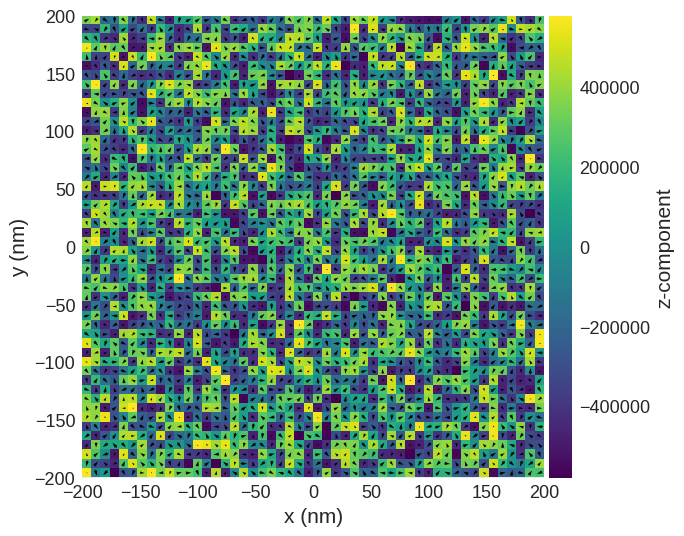

In [1]:
import discretisedfield as df
import numpy as np
import micromagneticmodel as mm

np.random.seed(2)

mesh = df.Mesh(
    p1=(-200e-9, -200e-9, -20e-9),
    p2=(200e-9, 200e-9, 20e-9),
    cell=(8e-9, 8e-9, 10e-9),
)

system = mm.System(name='mag2exp_demo')

# Values for MnSi
system.energy = (
    mm.Exchange(A=15e-12)
    + mm.DMI(D=3e-3, crystalclass="T")
    + mm.UniaxialAnisotropy(K=0.2e6, u=(0, 0, 1))
    + mm.Zeeman(H=(0, 0, 3.5e5))
    + mm.Demag()
)

Ms = 580e3

def m_fun(pos):
    return 2 * np.random.rand(3) - 1

# create system with above geometry and initial magnetisation
system.m = df.Field(mesh, nvdim=3, value=m_fun, norm=Ms)

system.m.sel("z").mpl()

Relax the system

Running OOMMF (ExeOOMMFRunner)[2023/08/09 13:58]... (4.9 s)


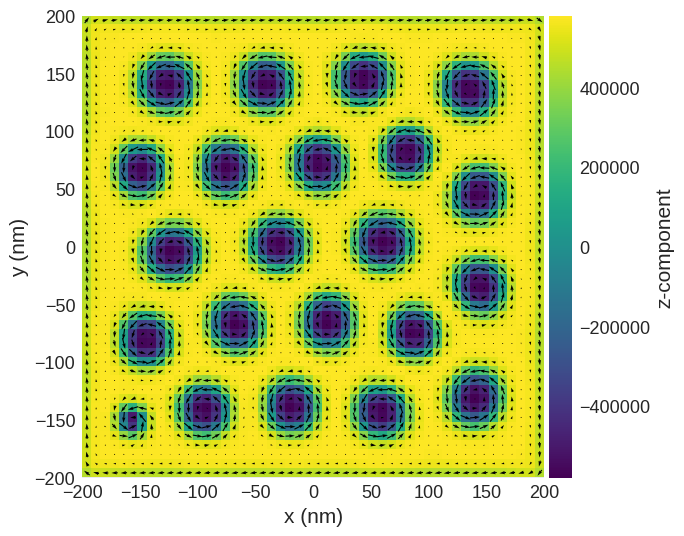

In [2]:
import oommfc as oc

md = oc.MinDriver()
md.drive(system)

system.m.sel("z").mpl()

This magnetisation texture shows a Bloch skyrmion lattice.

## Microscopy techniques

Microscopy techniques enable the imaging of magnetic structures on a nanometre length
scale. This makes them powerful techniques to corroborate micromagnetic
simulations due to the similarity of the length scales probed.

In this notebook we will look into two microscopy techniques that `mag2exp` can simulate:
- Lorentz TEM
- X-ray 

Further details of more microscopy techniques are given in the `mag2exp` package documentation and the api reference. 

### Lorentz TEM

Lorentz Transmission Electron Microscopy (Lorentz TEM) is a popular method for imaging magnetic structures in thin lamellae of magnetic materials.


Transmission electron microscopy involves electrons being accelerated through a voltage typically between 60--300~kV. This electron beam travels down the microscope column and passes through a thin sample called a lamella. The direction of the electron beam is defined to be in the negative $z$ direction in the technique frame of `mag2exp`.

If the sample is magnetic, the electrons are deflected by the Lorentz force as they pass through. This means that electron microscopy is sensitive to the magnetic flux density $\textbf{B}$ from the sample (rather than the magnetisation $\textbf{M}$) and that due to the nature of the cross-product, it is sensitive only to the component of $\textbf{B}$ normal to the electron beam.

The effect of the beam deflection is that the electrons emerge from the sample having acquired a phase shift. This phase shift can be calculated using `mag2exp`.

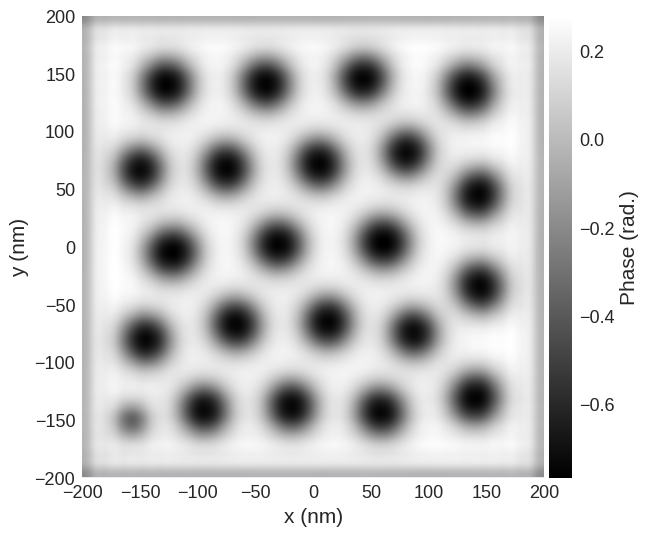

In [3]:
import mag2exp

phase, ft_phase = mag2exp.ltem.phase(system.m)

phase.mpl.scalar(cmap="gray", interpolation="spline16", colorbar_label="Phase (rad.)")


The phase can be directly recovered by Lorentz TEM techniques such as electron holography. 

Another common technique is Lorentz TEM defocus imaging. This is where the microscope is defocused so the images produced become sensitive to the magnetisation of the sample.

Once the phase is measured, the defocus images can be obtained using `mag2exp`.

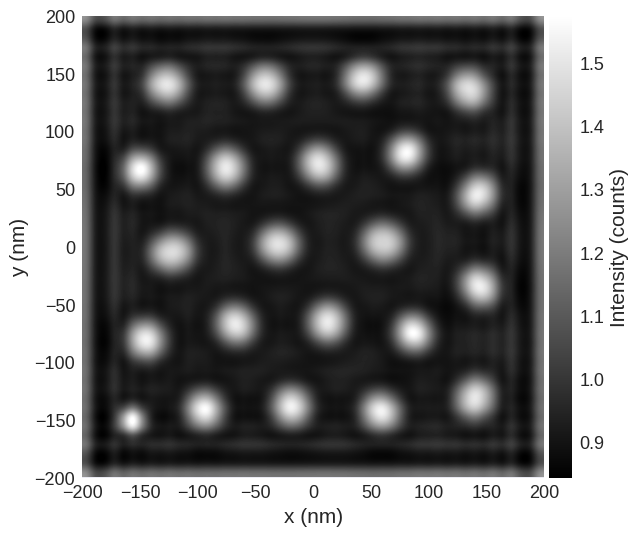

In [4]:
df_image = mag2exp.ltem.defocus_image(phase, voltage=300e3, df_length=-0.2e-3)

df_image.mpl.scalar(
    cmap="gray",
    interpolation="spline16",
    colorbar_label="Intensity (counts)"
)


### X-ray Holography
A technique which is complmentary to Lorentz TEM is X-ray holography. X-ray holography is a technique which uses circularly polarised light to take
advantage of the magnetic circular dichroism effect. In x-ray holography, a coherent beam of circularly polarised x-rays is incident
on the sample and a reference slit.
The scattered x-rays interfere and form a hologram which is recorded by the
detector. The measured hologram can subsequently be combined with a differential filter
and Fourier transformed to reconstruct the holographic image which contains
information on the out-of-plane magnetisation of the sample.

For the x-ray holography technique in `mag2exp`, the technique
reference frame is defined with the incident beam propagating along the negative $z$
direction

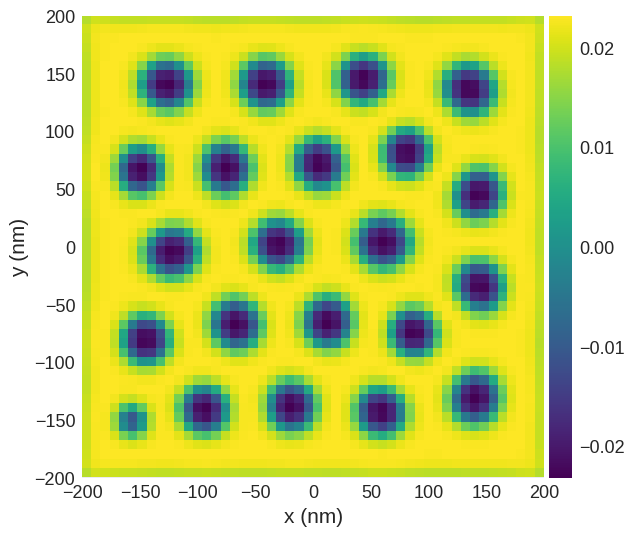

In [5]:
holo = mag2exp.x_ray.holography(system.m)

holo.mpl()

Now is good time to introduce some helper functionality known as `quick_plots`.
The `quick_plots` submodule, contains functions to each create an image that
shows the outcome of the respective experimental techniques with a single line of
Python code -- trading ease of use against a lack of flexibility.

An example of this for X-ray holography is shown below with built in functionality for convolutions with a Gaussian of a certain `fwhm` to create more experimentally realistic images.

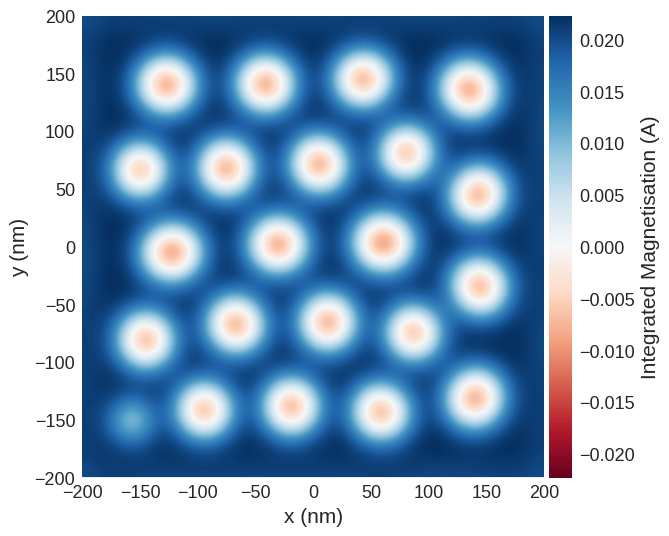

In [6]:
mag2exp.quick_plots.x_ray_holography(system.m, fwhm=(30e-9, 30e-9))

## Reciprocal space
`mag2exp` also has the functionality to look at reciprocal space techniques such as Small Angle Neutron Scattering and Small Angle X-ray Scattering.
Reciprocal space techniques are powerful techniques to examine the periodicity
of magnetic structures.

### Small Angle Neutron Scattering

In small-angle neutron scattering (SANS) a beam of neutrons is incident on a
sample in a transmission geometry and the neutrons scatter as they travel
through the sample due to both nuclear and magnetic forces. In `mag2exp`
only scattering due to the magnetisation of the sample is considered. The
scattering pattern indicates the periodicity of the magnetic structure. The
polarisation of the neutrons before and after scattering can be controlled to
yield more information about the magnetisation structure from spin-flip cross
sections. For the SANS technique in `mag2exp`, the technique reference
frame is defined to be the same as the sample reference frame.

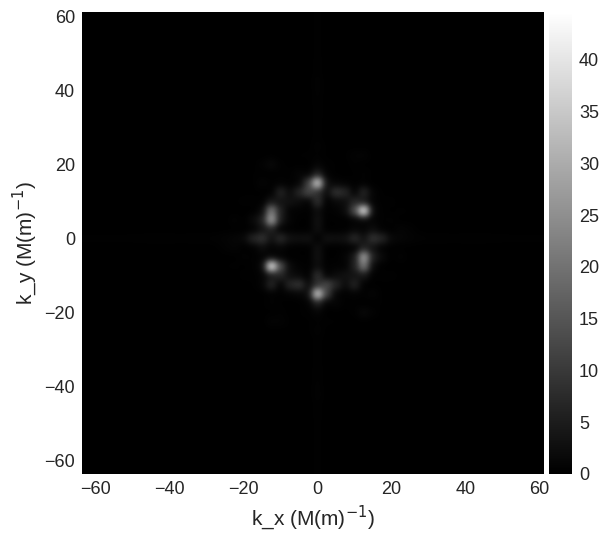

In [7]:
cs = mag2exp.sans.cross_section(system.m, method="unpol", polarisation=(0, 0, 1))

cs.sel(k_z=0).mpl.scalar(cmap='gray', interpolation='gaussian')

## Magnetometry

Magnetometry techniques are a widely used and important tool for characterising
many materials. These techniques are usually bulk sensitive and used to examine
properties of magnetisation.
In `mag2exp` we can look at quantities such as the magnetisation,
the spatially averaged magnetisation direction and magnetic torque.

### Torque magnetometry

Torque magnetometry is a technique where a sample is placed in an external
magnetic field and the torque on the sample due to the externally applied field is measured. This technique is
commonly used to measure the anisotropy of materials by applying a large enough
magnetic field to saturate the sample and then rotating the sample relative to the field to obtain the easy
and hard axes. However, it can be difficult to interpret the experimental
results of torque magnetometry techniques due to effects such as demagnetisation.
It is also hard to predict the torque magnetometry results for magnetic states that
are not in the saturated state. `mag2exp` opens another avenue
for interpretation of results by computationally simulating the
torque of a magnetic state.

In this simultion we apply a 3 T field along the $z$ direction and rotate it the th $yz$ plane in 51 steps. The torque at each of these steps is measured and then plotted.

In [8]:
angles = np.linspace(0, 2 * np.pi, 51)

H_mag = 2.38e6

torque_val_x = np.full_like(angles, np.nan)
for i, angle in enumerate(angles):
    system.energy.zeeman.H = (0, H_mag * np.sin(angle), H_mag * np.cos(angle))
    md.drive(system, verbose=0)
    torque_val_x[i], _, _ = mag2exp.magnetometry.torque(
        system.m, system.energy.zeeman.H
    )

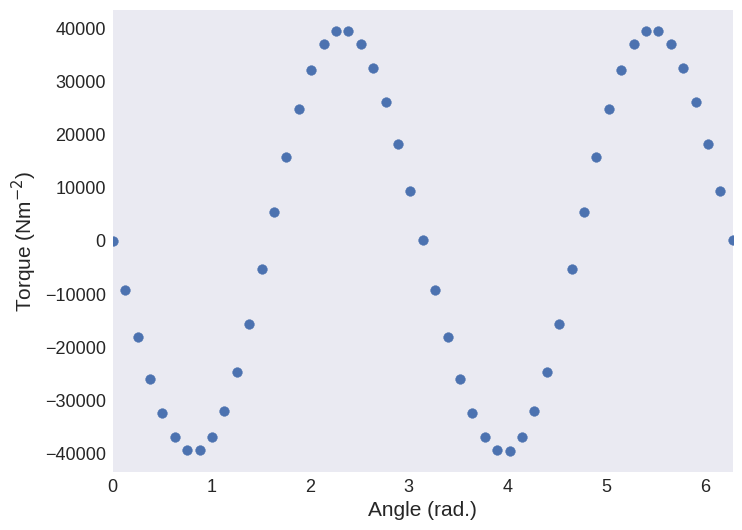

In [9]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(dpi=100)
ax.scatter(angles, torque_val_x)
ax.set_xlabel("Angle (rad.)")
ax.set_ylabel(r"Torque (Nm$^{-2}$)")
ax.set_xlim([0, 2 * np.pi])
plt.show()

More in-depth tutorials of these and more techniques are given in the `mag2exp` package documentation and the API reference. 